In [1]:
%matplotlib inline
#!/home/leonard/Applications/anaconda3/bin/python
import sys, traceback
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')
from plantcv import plantcv as pcv

class options:
    def __init__(self):
        self.image = "img/tutorial_images/vis/original_image.jpg"
        self.debug = "plot"
        self.writeimg = True
        self.result = "./vis_tutorial_results"
        self.outdir = "."
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


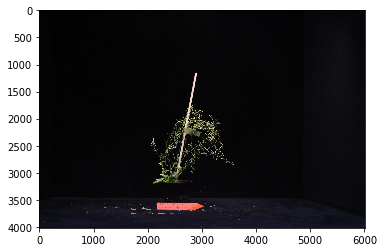

In [2]:
### Main pipeline

    # Read image
    img, path, filename = pcv.readimage("DSC_1356.JPG")

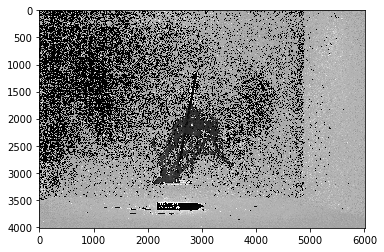

In [3]:
    # Convert RGB to HSV and extract the hue channel
    h = pcv.rgb2gray_hsv(img, "h")
    #plt.imshow(h)
    #plt.show()

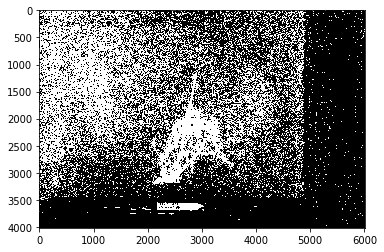

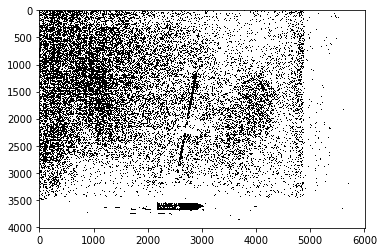

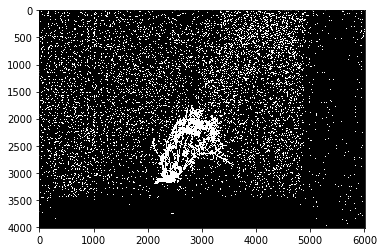

In [4]:
    # Threshold the saturation image
    h_thresh1 = pcv.threshold.binary(h, 110, 255, "dark")
    h_thresh2 = pcv.threshold.binary(h, 20, 255, "light")
    h_thresh = pcv.logical_and(h_thresh1, h_thresh2)
    #plt.imshow(h_thresh)
    #plt.show()

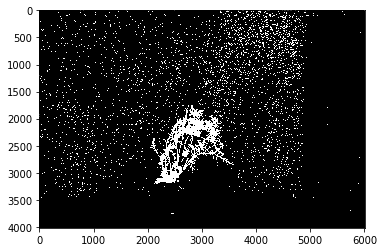

In [5]:
    # Median Blur
    h_mblur = pcv.median_blur(h_thresh, 5)
    #h_cnt = pcv.median_blur(h_thresh, 5)

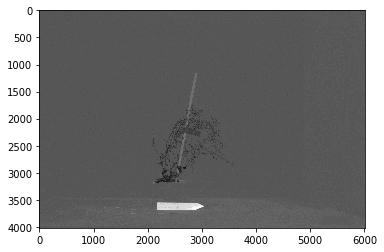

In [6]:
    # Convert RGB to LAB and extract the Blue channel
    b = pcv.rgb2gray_lab(img, "a")

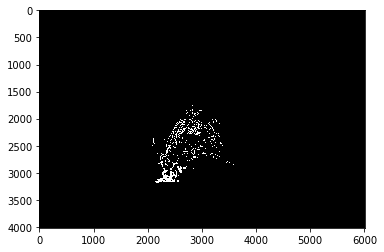

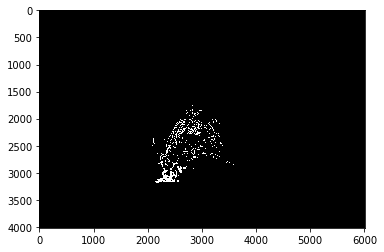

In [7]:
    # Threshold the blue image
    b_thresh = pcv.threshold.binary(b, 120, 255, "dark")
    b_cnt = pcv.threshold.binary(b, 120, 255, "dark")

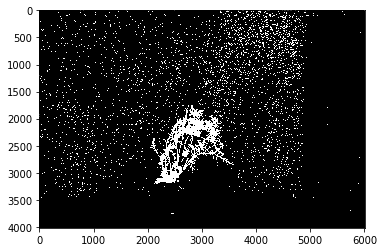

In [8]:
   # Join the thresholded saturation and blue-yellow images
    bh = pcv.logical_or(h_mblur, b_cnt)

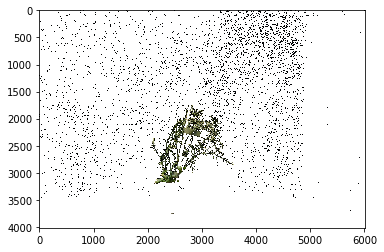

In [9]:
    # Apply Mask (for VIS images, mask_color=white)
    masked = pcv.apply_mask(img, bh, "white")

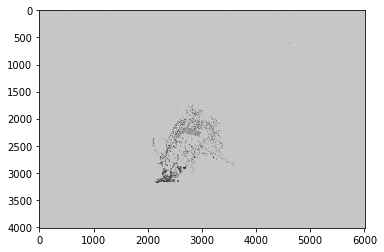

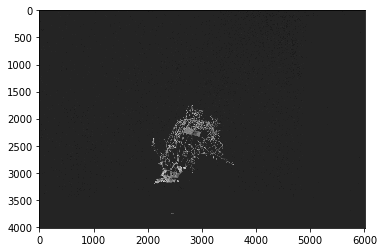

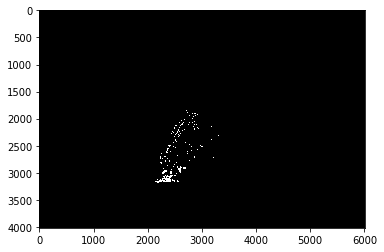

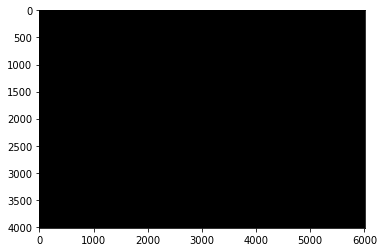

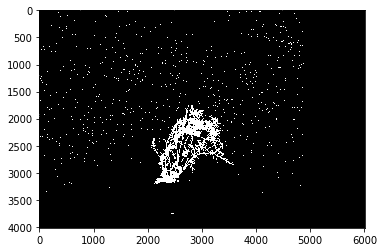

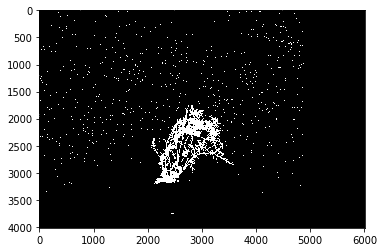

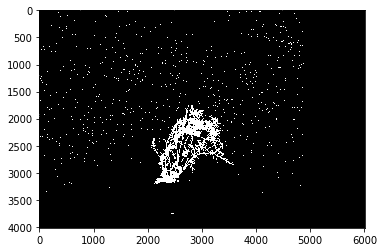

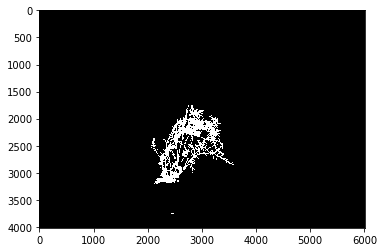

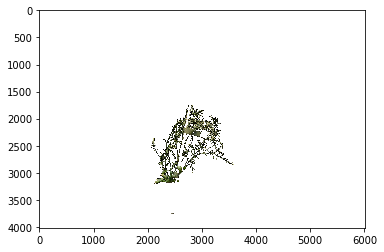

In [10]:

    # Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
    masked_a = pcv.rgb2gray_lab(masked, "a")
    masked_b = pcv.rgb2gray_lab(masked, "b")

    # Threshold the green-magenta and blue images
    maskeda_thresh = pcv.threshold.binary(masked_a, 115, 255, "dark")
    maskeda_thresh1 = pcv.threshold.binary(masked_a, 135, 255, "light")
    maskedb_thresh = pcv.threshold.binary(masked_b, 128, 255, "light")

    # Join the thresholded saturation and blue-yellow images (OR)
    ab1 = pcv.logical_or(maskeda_thresh, maskedb_thresh)
    ab = pcv.logical_or(maskeda_thresh1, ab1)

    # Fill small objects
    ab_fill = pcv.fill(ab, 200)

    # Apply mask (for VIS images, mask_color=white)
    masked2 = pcv.apply_mask(masked, ab_fill, "white")

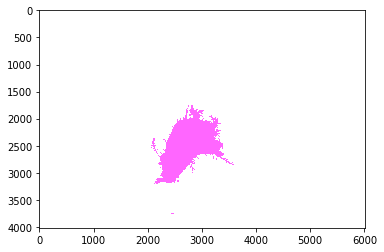

In [11]:
# Identify objects
    id_objects, obj_hierarchy = pcv.find_objects(masked2, ab_fill)

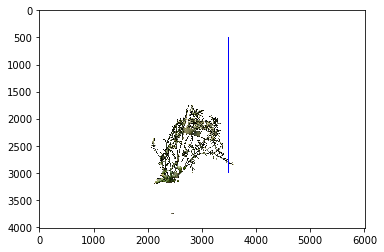

In [12]:
 # Define ROI
    roi1, roi_hierarchy= pcv.roi.rectangle(x=500, y=500, h=2500, w=3000, img=masked2)

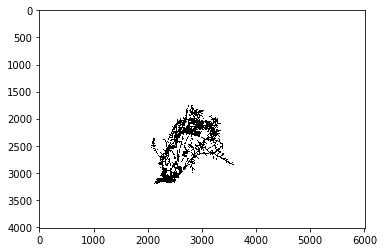

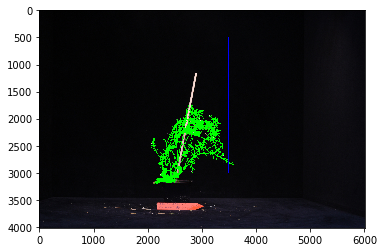

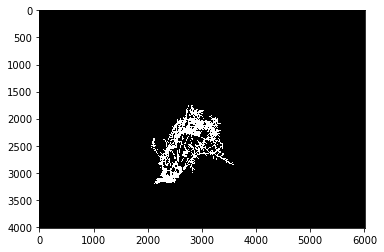

In [13]:

    # Decide which objects to keep
    roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img, 'partial', roi1, roi_hierarchy, id_objects, obj_hierarchy)

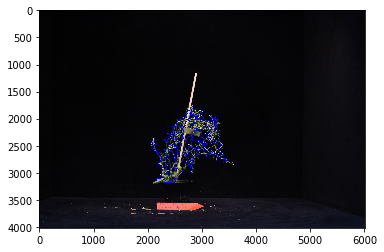

In [14]:
# Object combine kept objects
    obj, mask = pcv.object_composition(img, roi_objects, hierarchy3)

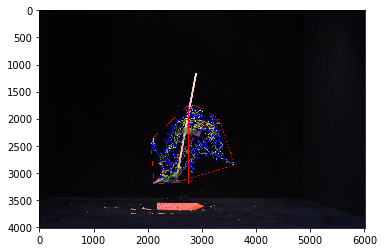

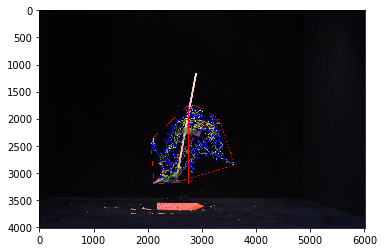

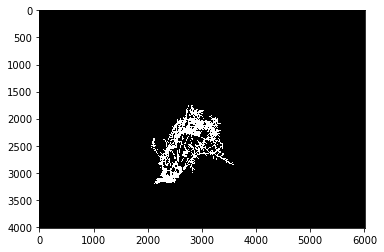

In [15]:
############### Analysis ################

outfile=False
if args.writeimg==True:
    outfile=args.outdir+"/"+filename

    # Find shape properties, output shape image (optional)
    shape_header, shape_data, shape_imgs = pcv.analyze_object(img, obj, mask)
    
    # analysis_images contains two images, the original image with shape data drawn on, and the mask
shape_info_img, shape_mask = shape_imgs
# Plot them out 
pcv.plot_image(shape_info_img)
pcv.plot_image(shape_mask)
pcv.print_image(shape_info_img, "outline_2.png")
pcv.print_image(shape_mask, "mask_2.png")


In [16]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)

# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   bins - Number of color bins (0-256)
#   hist_plot_type - None (default), 'all', 'rgb', 'lab', or 'hsv'
#                    This is the data to be printed to the SVG histogram file  
color_header, color_data, color_histogram = pcv.analyze_color(img, kept_mask, 256, 'all')

# color_histogram is a list containing the histogram image, store it 
color_hist = color_histogram[0]

/home/leonard/Applications/anaconda3/envs/plantcv/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


<ggplot: (8752357568029)>


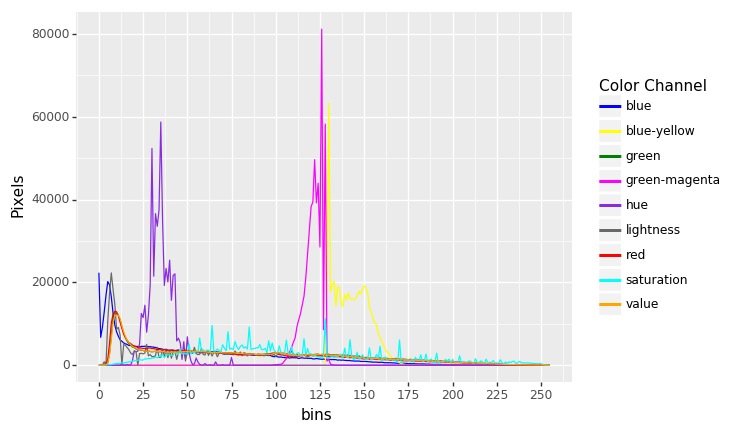

In [17]:
# The color_histogram image is a plotnine ggplot; we can plot it to the screen without pcv.plot_image
pcv.plot_image(color_hist)

/home/leonard/Applications/anaconda3/envs/plantcv/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


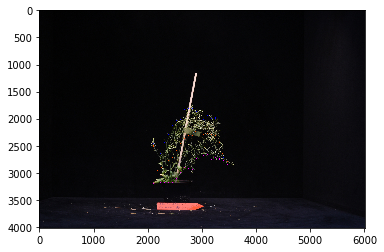

In [18]:
# Divide plant object into twenty equidistant bins and assign pseudolandmark points based upon their 
# actual (not scaled) position. Once this data is scaled this approach may provide some information 
# regarding shape independent of size.

top_x, bottom_x, center_v_x = pcv.x_axis_pseudolandmarks(obj, mask, img)

/home/leonard/Applications/anaconda3/envs/plantcv/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


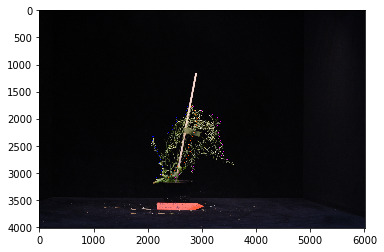

In [19]:
top_y, bottom_y, center_v_y = pcv.y_axis_pseudolandmarks(obj, mask, img)

In [20]:
# Write shape and color data to results file
# Result file will go to the notebooks folder! 
result = open(args.result,"a")
result.write('\t'.join(map(str,shape_header)))
result.write("\n")
result.write('\t'.join(map(str,shape_data)))
result.write("\n")
result.write('\t'.join(map(str,color_header)))
result.write("\n")
result.write('\t'.join(map(str,color_data)))
result.write("\n")
result.close()